# Homework 3
## Decision Trees
### Arya Rahmanian
### CSCE 633

### Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Part A - Data Preprocessing

In [33]:
df = pd.read_csv('loan_dataset.csv')
print(df.head)
df.dropna(inplace=True)

<bound method NDFrame.head of       Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849            

##### Dataset description
The data consists of 614 indivduals requesting loans and whether they recieved them. The features that are in the dataset include their financials, marital status, and details of the loan they are applying for. The label we are training on is whether or not they recieved the loan.

#### One hot encoding

In [34]:
#get features and label
X = df.drop(columns=['Loan_Status'])
y = df[['Loan_Status']]

# separate numerical columns
X_cat = X.select_dtypes(exclude=['int64', 'float64'])
X_num = X.select_dtypes(include=['int64', 'float64'])

# one-hot encode categorical features
X_cat = pd.get_dummies(X_cat)

X = pd.concat([X_num, X_cat], axis=1)

# Transform the label
LoanStatus2number_dict = {
    'N': 0,
    'Y': 1
}
y = y.replace({"Loan_Status": LoanStatus2number_dict})

X.replace({'3+': 3, 'Urban': 0, 'Rural': 1, 'Semiurban': 2}, inplace=True)

# Convert all data to numerical format
X = X.astype(float)
y = y.astype(int)

print(X.head)
print(y.head)

<bound method NDFrame.head of      ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
1             4583.0             1508.0       128.0             360.0   
2             3000.0                0.0        66.0             360.0   
3             2583.0             2358.0       120.0             360.0   
4             6000.0                0.0       141.0             360.0   
5             5417.0             4196.0       267.0             360.0   
..               ...                ...         ...               ...   
609           2900.0                0.0        71.0             360.0   
610           4106.0                0.0        40.0             180.0   
611           8072.0              240.0       253.0             360.0   
612           7583.0                0.0       187.0             360.0   
613           4583.0                0.0       133.0             360.0   

     Credit_History  Loan_ID_LP001003  Loan_ID_LP001005  Loan_ID_LP001006  \
1               

In [35]:
# Split data into train, valid, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# combine features and labels for the tree
train_data = np.hstack((X_train.values, y_train.values.reshape(-1, 1)))
val_data = np.hstack((X_val.values, y_val.values.reshape(-1, 1)))
test_data = np.hstack((X_test.values, y_test.values.reshape(-1, 1)))

### Part B - Decision Tree Implementation

In [36]:
class Node:
    def __init__(self, split_val, data):
        self.split_val = split_val
        self.data = data
        self.left = None
        self.right = None

In [37]:
class TreeRegressor:
    def __init__(self, data, max_depth):
        self.data = data
        self.max_depth = max_depth

    def build_tree(self):
        root = self.get_best_split(self.data)
        self.split(root, 1)
        return root

    def mean_squared_error(self, left_split, right_split):
        splits = [left_split, right_split]
        mse = 0.0
        for group in splits:
            size = float(len(group))
            if size == 0:
                continue
            mean_group = self.to_terminal(group)
            mse += sum([(row[-1] - mean_group) ** 2 for row in group]) / size
        return mse

    def split(self, node, depth):
        left, right = node.data['groups']
        if not left or not right:
            node.left = node.right = self.to_terminal_node(left + right)
            return
        if depth >= self.max_depth:
            node.left, node.right = self.to_terminal_node(left), self.to_terminal_node(right)
            return
        if len(left) <= 1:
            node.left = self.to_terminal_node(left)
        else:
            node.left = self.get_best_split(left)
            self.split(node.left, depth + 1)
        if len(right) <= 1:
            node.right = self.to_terminal_node(right)
        else:
            node.right = self.get_best_split(right)
            self.split(node.right, depth + 1)

    def get_best_split(self, data):
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(len(data[0]) - 1):
            for row in data:
                groups = self.one_step_split(index, row[index], data)
                mse = self.mean_squared_error(groups[0], groups[1])
                if mse < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], mse, groups
        node = Node(b_value, data={'index': b_index, 'value': b_value, 'groups': b_groups})
        return node

    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return np.mean(outcomes).item()

    def to_terminal_node(self, group):
        val = self.to_terminal(group)
        return Node(val, {'value': val})

    def one_step_split(self, index, value, data):
        left, right = list(), list()
        for row in data:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right

def compare_node_with_threshold(node, row):
    return row[node.data['index']] < node.split_val

def predict(node, row, comparator):
    if node.left is None and node.right is None:
        return node.split_val
    if comparator(node, row):
        return predict(node.left, row, comparator)
    else:
        return predict(node.right, row, comparator)


In [38]:
class TreeClassifier(TreeRegressor):
    def gini_index(self, left_split, right_split, classes):
        splits = [left_split, right_split]
        n_instances = float(sum([len(group) for group in splits]))
        gini = 0.0
        for group in splits:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = [row[-1] for row in group].count(class_val) / size
                score += p * p
            gini += (1.0 - score) * (size / n_instances)
        return gini

    def get_best_split(self, data):
        class_values = list(set(row[-1] for row in data))
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(len(data[0]) - 1):
            for row in data:
                groups = self.one_step_split(index, row[index], data)
                score = self.gini_index(groups[0], groups[1], class_values)
                if score < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], score, groups
        node = Node(b_value, data={'index': b_index, 'value': b_value, 'groups': b_groups})
        return node

    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key=outcomes.count)

In [39]:
def evaluate_regression_tree(tree, val_data):
    predictions = [predict(tree, row, compare_node_with_threshold) for row in val_data]
    actual = [row[-1] for row in val_data]
    mse = np.mean([(pred - act)**2 for pred, act in zip(predictions, actual)])
    return mse

def evaluate_classification_tree(tree, val_data):
    predictions = [predict(tree, row, compare_node_with_threshold) for row in val_data]
    actual = [row[-1] for row in val_data]
    accuracy = sum([pred == act for pred, act in zip(predictions, actual)]) / len(actual)
    return accuracy


Running max depth = 1
Running max depth = 2
Running max depth = 3
Running max depth = 4
Running max depth = 5
Running max depth = 6


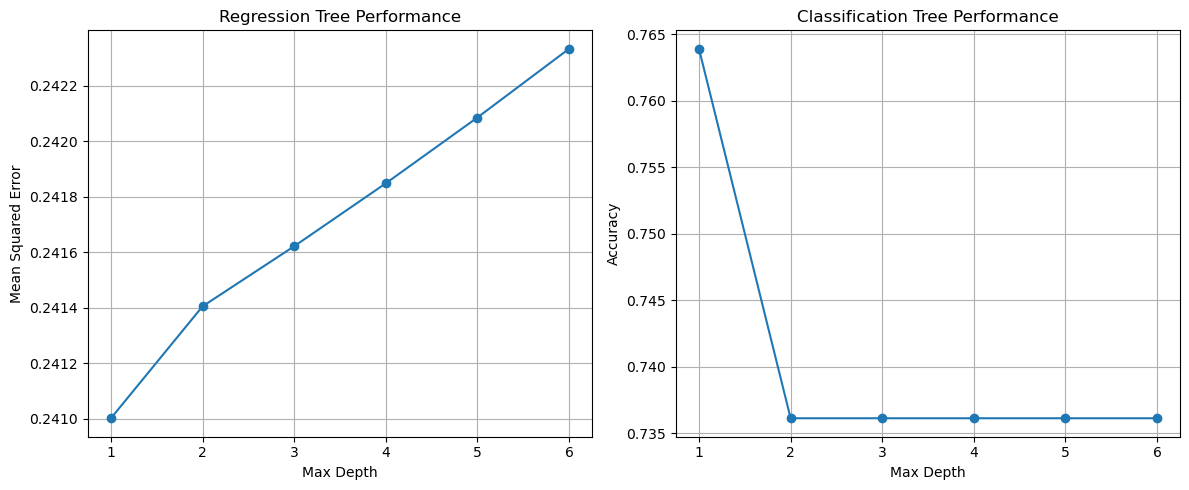

In [40]:
regression_mse_list = []
classification_accuracy_list = []
depths = [1, 2, 3, 4, 5, 6]

for max_depth in depths:
    print(f"Running max depth = {max_depth}")
    
    # regression tree training and validation
    regressor = TreeRegressor(train_data, max_depth=max_depth)
    regression_tree = regressor.build_tree()
    regression_mse = evaluate_regression_tree(regression_tree, val_data)
    regression_mse_list.append(regression_mse)

    # classification tree training and validation
    classifier = TreeClassifier(train_data, max_depth=max_depth)
    classification_tree = classifier.build_tree()
    classification_accuracy = evaluate_classification_tree(classification_tree, val_data)
    classification_accuracy_list.append(classification_accuracy)

# plotting the performance of regression trees
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(depths, regression_mse_list, marker='o')
plt.title('Regression Tree Performance')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.grid(True)

# plotting the performance of classification trees
plt.subplot(1, 2, 2)
plt.plot(depths, classification_accuracy_list, marker='o')
plt.title('Classification Tree Performance')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

### Choosing best model

In [41]:
best_regression_depth = depths[np.argmin(regression_mse_list)]
best_classification_depth = depths[np.argmax(classification_accuracy_list)]
print(f'Best max depth for regression tree: {best_regression_depth}')
print(f'Best max depth for classification tree: {best_classification_depth}')

best_regressor = TreeRegressor(train_data, max_depth=best_regression_depth)
best_regression_tree = best_regressor.build_tree()

best_classifier = TreeClassifier(train_data, max_depth=best_classification_depth)
best_classification_tree = best_classifier.build_tree()

Best max_depth for regression tree: 1
Best max_depth for classification tree: 1


In [42]:
regression_predictions = [predict(best_regression_tree, row, compare_node_with_threshold) for row in test_data]
regression_results = pd.DataFrame(regression_predictions, columns=['Predicted'])
regression_results.to_csv('Test Result 1.csv', index=False)


classification_predictions = [predict(best_classification_tree, row, compare_node_with_threshold) for row in test_data]
classification_results_df = pd.DataFrame(classification_predictions, columns=['Predicted'])
classification_results_df.to_csv('Test Result 2.csv', index=False)
